In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False)


In [2]:
# 데이터 가져오기
data = pd.read_csv('train.csv')
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# 데이터 파악
print('data.shape: ', data.shape)
print('='*40)
data.info()

data.shape:  (10886, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
# datetime 컬럼을 datetime 자료형으로 변환
data['datetime'] = pd.to_datetime(data['datetime'])
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month

# season, weather, day 카테고리형으로 변환
data['season'] = data['season'].astype('category')
data['weather'] = data['weather'].astype('category')
data['day'] = data['datetime'].dt.weekday.astype('category')

data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5


In [5]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['datetime', 'count'])
y = data['count']

# 원-핫 인코딩
X = pd.get_dummies(X)

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 학습
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

# 예측
y_pred = lr.predict(X_test)

# 평가
from sklearn.metrics import mean_squared_error, r2_score


mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

MSE: 0.00
RMSE: 0.00
R-squared: 1.00


### 잔차 분석(히스토그램)

잔차 평균: 0.00


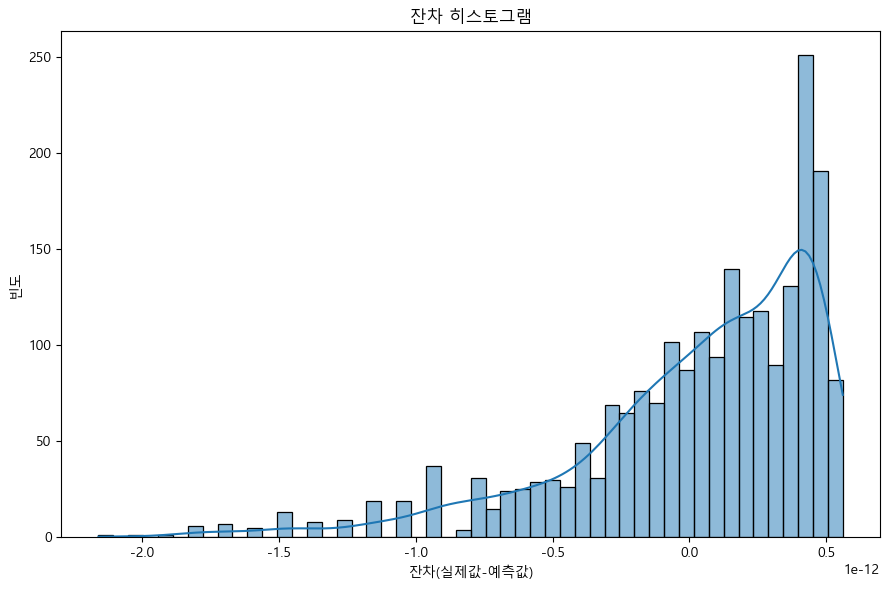

In [6]:
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# 잔차 = 실제값 - 예측값
residuals = y_test - y_pred

# 잔차 평균
residual_mean = np.mean(residuals)
print(f'잔차 평균: {residual_mean:.2f}')

# 잔차 히스토그램
plt.figure(figsize=(9,6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("잔차 히스토그램")
plt.xlabel("잔차(실제값-예측값)")
plt.ylabel("빈도")
plt.tight_layout()
plt.show()


해석
- 잔차평균은 0 이지만 좌우가 대칭적인 종 모양은 아님. 0 기준 우측에 대부분 값이 몰려있음.
- 모델에 체계적인 편향은 없으나 정규성을 만족한다고 하긴 어려움: QQ 플랏 통해 추가적으로 확인

잔차 분석(Q-Q 플랏)

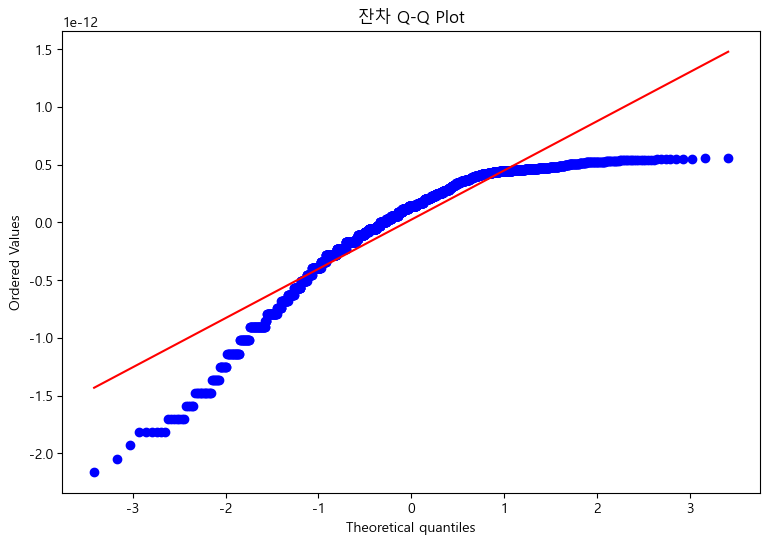

In [7]:
import scipy.stats as stats

plt.figure(figsize = (9,6))
stats.probplot(residuals, dist = stats.norm, plot = plt)
plt.title("잔차 Q-Q Plot")
plt.show()

# 대각선에 가까울 수록 정규분포를 따름

해석
- 대각선과 비교했을 때 잔차들이 많이 벗어나 있음을 확인 가능 > 정규분포를 따르지 않는다고 할 수 있음
- 정규성 가정 위배

### 데이터 전처리 - CORR, VIF

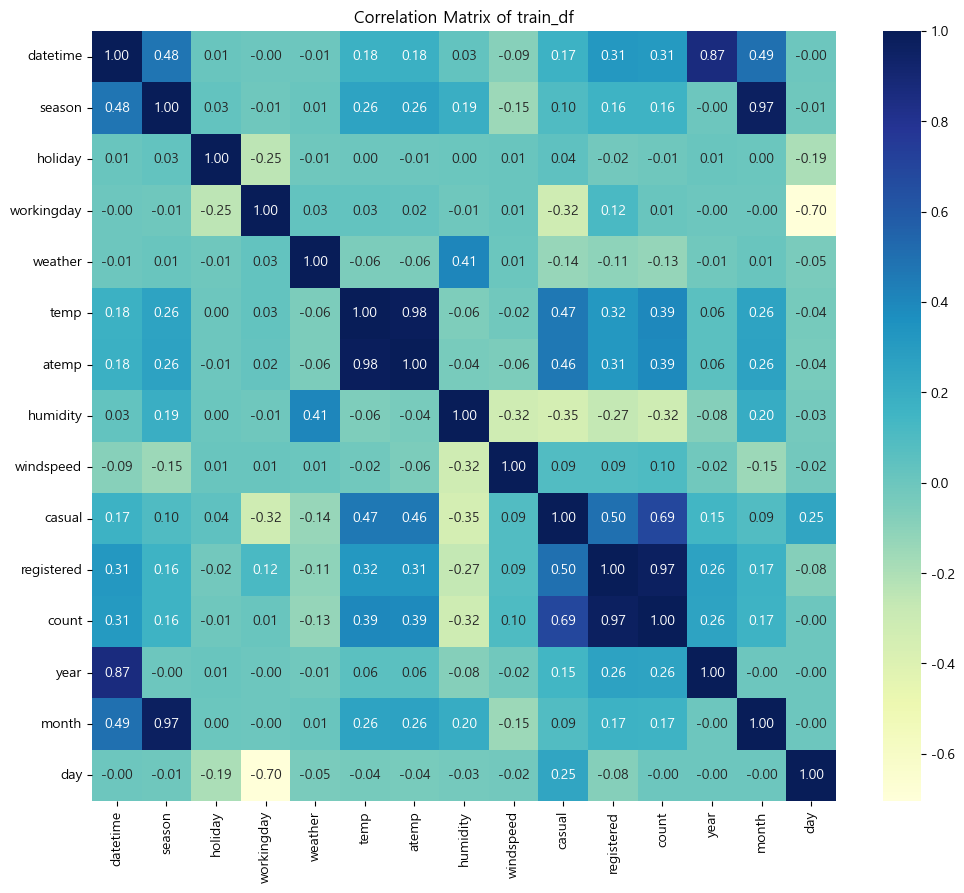

In [8]:
plt.figure(figsize=(12, 10))

sns.heatmap(data.corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix of train_df')
plt.show()

# corr: 두 변수 간 선형 관계의 정도

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = data
numeric_cols = X_vif.select_dtypes(include=['int64', 'float64']).columns

# 각각의 피쳐에 대해서 VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(X_vif[numeric_cols].values, i) for i in range(X_vif[numeric_cols].shape[1])]

print("VIF values:")
display(vif_data)

# VIF: 특정 변수가 다른 변수들의 선형 조합으로 얼마나 설명 가능한지의 정도

VIF values:


,feature,VIF
0,holiday,1.092201
1,workingday,4.033296
2,temp,263.945126
3,atemp,291.212885
4,humidity,6.948850
5,windspeed,2.910080
6,casual,inf
7,registered,inf
8,count,inf


In [10]:
# 변수 제거 후 다시 선형 회귀
X = data.drop(columns=['datetime', 'count', 'casual', 'registered', 'atemp'])
y = data['count']

# 원-핫 인코딩
X = pd.get_dummies(X)

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 학습
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

# 예측
y_pred = lr.predict(X_test)

# 평가
from sklearn.metrics import mean_squared_error, r2_score


mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

MSE: 21969.51
RMSE: 148.22
R-squared: 0.33


### 잔차 재분석(히스토그램)

잔차 평균: 2.72


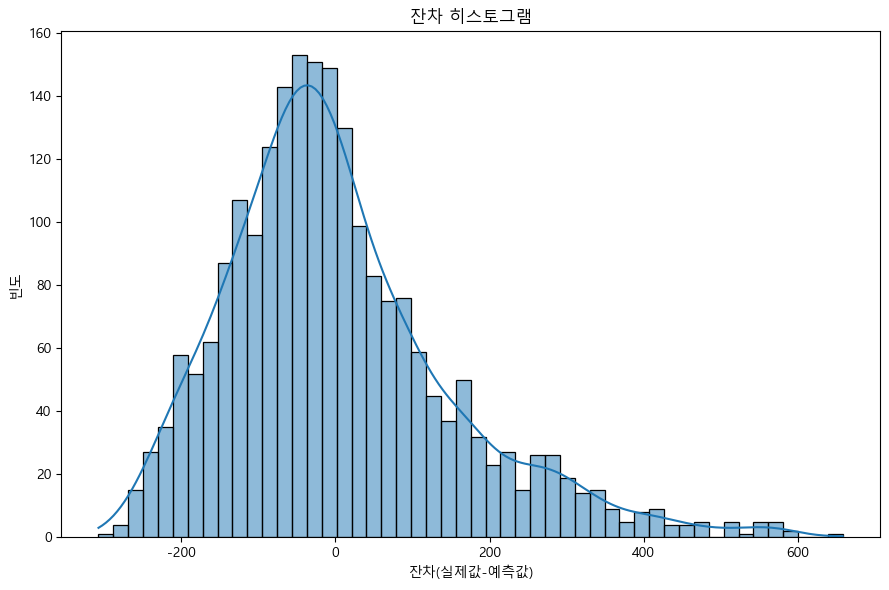

In [11]:
# 잔차
residuals = y_test - y_pred

# 잔차 평균
residual_mean = np.mean(residuals)
print(f'잔차 평균: {residual_mean:.2f}')

# 잔차 히스토그램
plt.figure(figsize=(9,6))
sns.histplot(residuals, kde=True, bins=50)
plt.title("잔차 히스토그램")
plt.xlabel("잔차(실제값-예측값)")
plt.ylabel("빈도")
plt.tight_layout()
plt.show()

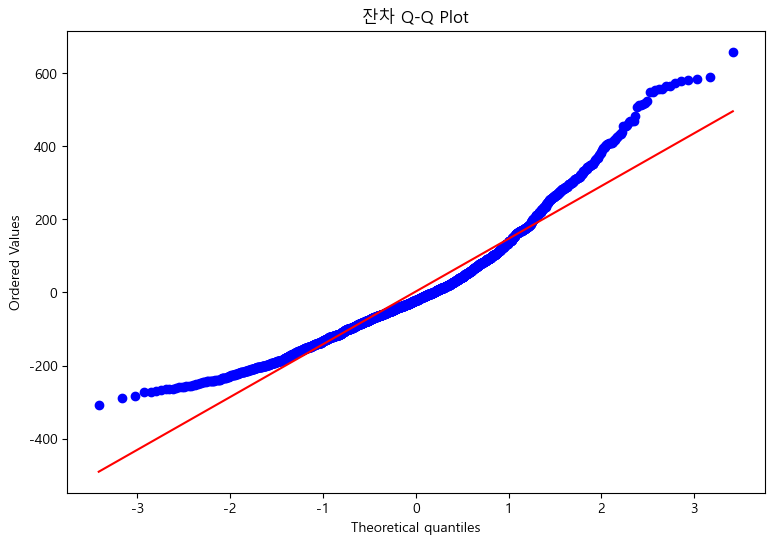

In [12]:
import scipy.stats as stats

plt.figure(figsize = (9,6))
stats.probplot(residuals, dist = stats.norm, plot = plt)
plt.title("잔차 Q-Q Plot")
plt.show()

해석
- 다중공선성 변수로 인해 모델이 과적합되어 잔차 분포가 정규 분포를 띄지 않았었음
- 변수를 제거하여 과적합을 낮추자, 오차의 분포가 퍼지며 점차 정규 분포를 띄게 되었음
- 그러나 이로 인해 모델의 설명력이 매우 낮아짐 > 회귀의 전제조건(정규성, 등분산성, 독립성)과 트레이드오프 관계
- 모델의 성능을 제고하려면 랜덤포레스트 모델 같은 비선형 모델이 타당해보임